# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [2]:
from glob import glob

paths = sorted(glob("data/*.csv"))
paths

['data\\movies_test.csv', 'data\\movies_train.csv', 'data\\submission.csv']

In [3]:
train, test = pd.read_csv(paths[1]), pd.read_csv(paths[0])

train.shape, test.shape

((600, 12), (243, 11))

In [4]:
set(train.columns) - set(test.columns)

{'box_off_num'}

In [5]:
# train과 test의 데이터를 출력해봅니다
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [7]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
train.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [9]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
test.describe().round(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [10]:
# train
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [11]:
# test
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

Text(0.5, 1.0, 'Test - Missing')

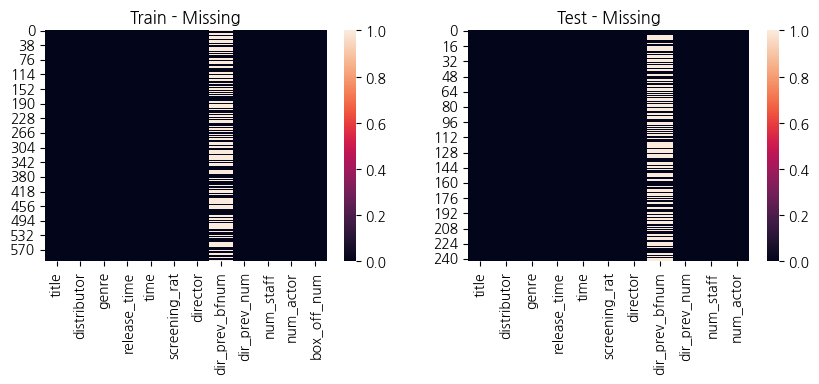

In [12]:
# 결측치를 시각화해봅니다
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
sns.heatmap(train.isnull(), ax=axes[0])
sns.heatmap(test.isnull(), ax=axes[1])
axes[0].set_title("Train - Missing")
axes[1].set_title("Test - Missing")

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [13]:
# \(|주|\) 는 데이터에서 제거해줍니다
# 4번째 데이터의 쇼박스(주)미디어플렉스 경우도 (주)를 뺴도 될까?
train["distributor"] = train["distributor"].str.replace("\(|주|\)", "")

Text(0.5, 1.0, 'Test - distributor')

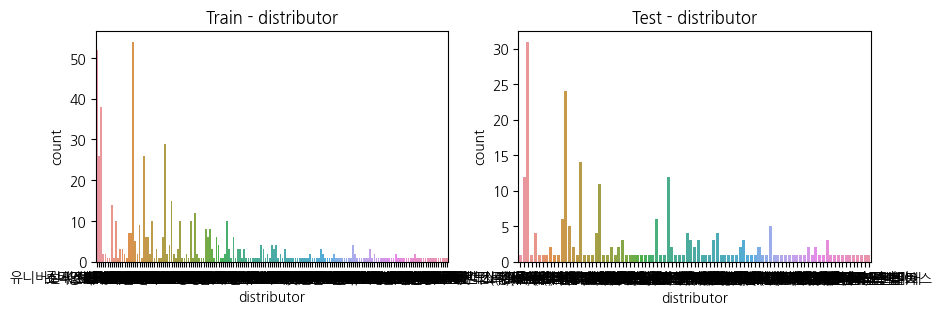

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
sns.countplot(data=train, x="distributor", ax=axes[0])
sns.countplot(data=test, x="distributor", ax=axes[1])
axes[0].set_title("Train - distributor")
axes[1].set_title("Test - distributor")

In [15]:
# 정규 표현식으로 문자와 숫자만 
# re,sub("바꾸고 싶은 문자", "바꿀문자", 문자열=x, 바꿀횟수)
# ^는 not
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

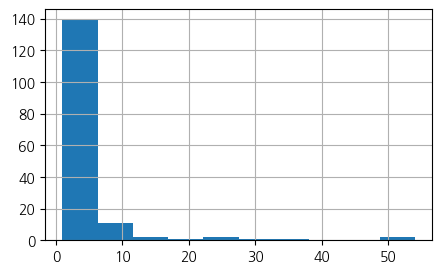

In [16]:
_ = train["distributor"].value_counts().hist(figsize=(5,3))

In [17]:
# pd.set_option('display.max_columns', None)

In [18]:
test["distributor"].value_counts()

CJ엔터테인먼트        31
롯데엔터테인먼트        24
주마운틴픽쳐스         14
골든타이드픽처스        12
주쇼박스            12
                ..
웃기씨네             1
오픈유컬쳐            1
CJEMPictures     1
크리에이티브컴즈주        1
주씨타마운틴픽쳐스        1
Name: distributor, Length: 92, dtype: int64

In [19]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다
def distributor_band(x):
    temp_list = pd.DataFrame(train["distributor"].value_counts()>15)
    중대형 = temp_list.loc[temp_list["distributor"]==True].index
    
    if x in 중대형:
        return "중대형"
    else:
        return "소형"

In [20]:
test["distributor"].apply(distributor_band).value_counts()

소형     165
중대형     78
Name: distributor, dtype: int64

In [21]:
train["distributor"].apply(distributor_band).value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [22]:
# 위 함수를 train과 test에 모두 적용합니다
test["distributor"]=test["distributor"].apply(distributor_band)
train["distributor"]= train["distributor"].apply(distributor_band)

In [23]:
train["distributor"].value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [24]:
test["distributor"].value_counts()

소형     165
중대형     78
Name: distributor, dtype: int64

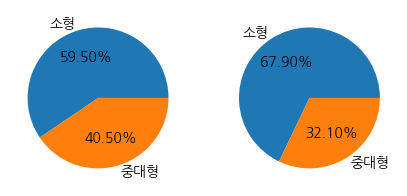

In [25]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].pie(train["distributor"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [26]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [29]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다
rank = {'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5, '미스터리' : 6, 
                 '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션': 11, '느와르' : 12}

In [30]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [31]:
train[["genre", "rank_genre"]].head()

,genre,rank_genre
0,액션,11
1,느와르,12
2,액션,11
3,코미디,9
4,코미디,9


In [32]:
# 인코딩 전의 장르 컬럼은 버려줍니다
train = train.drop("genre", axis=1)
train.columns

Index(['title', 'distributor', 'release_time', 'time', 'screening_rat',
       'director', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'box_off_num', 'rank_genre'],
      dtype='object')

In [33]:
test=test.drop("genre", axis=1)
test.columns

Index(['title', 'distributor', 'release_time', 'time', 'screening_rat',
       'director', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'rank_genre'],
      dtype='object')

### release_time: 개봉일

In [34]:
# 개봉일의 데이터타입은 datetime으로 변경합니다
train["release_time"] = pd.to_datetime(train["release_time"])
train["release_time"].head(2)

0   2012-11-22
1   2015-11-19
Name: release_time, dtype: datetime64[ns]

In [35]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다
train["year"] = train["release_time"].dt.year
train["month"] = train["release_time"].dt.month
train["day"] = train["release_time"].dt.day
train["dayofweek"] = train["release_time"].dt.dayofweek

train[["year", "month", "day", "dayofweek"]].head()

,year,month,day,dayofweek
0,2012,11,22,3
1,2015,11,19,3
2,2013,6,5,2
3,2012,7,12,3
4,2010,11,4,3


In [36]:
test["release_time"] = pd.to_datetime(test["release_time"])
test["release_time"].head(2)

0   2010-01-07
1   2010-01-14
Name: release_time, dtype: datetime64[ns]

In [37]:
test["year"] = test["release_time"].dt.year
test["month"] = test["release_time"].dt.month
test["day"] = test["release_time"].dt.day
test["dayofweek"] = test["release_time"].dt.dayofweek

test[["year", "month", "day", "dayofweek"]].head()

,year,month,day,dayofweek
0,2010,1,7,3
1,2010,1,14,3
2,2010,1,28,3
3,2010,2,4,3
4,2010,2,18,3


In [38]:
# 기존 데이터는 삭제합니다
train = train.drop("release_time", axis=1)
train.columns

Index(['title', 'distributor', 'time', 'screening_rat', 'director',
       'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'box_off_num', 'rank_genre', 'year', 'month', 'day', 'dayofweek'],
      dtype='object')

In [39]:
test = test.drop("release_time", axis=1)
test.columns

Index(['title', 'distributor', 'time', 'screening_rat', 'director',
       'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'rank_genre', 'year', 'month', 'day', 'dayofweek'],
      dtype='object')

<AxesSubplot:xlabel='dayofweek', ylabel='count'>

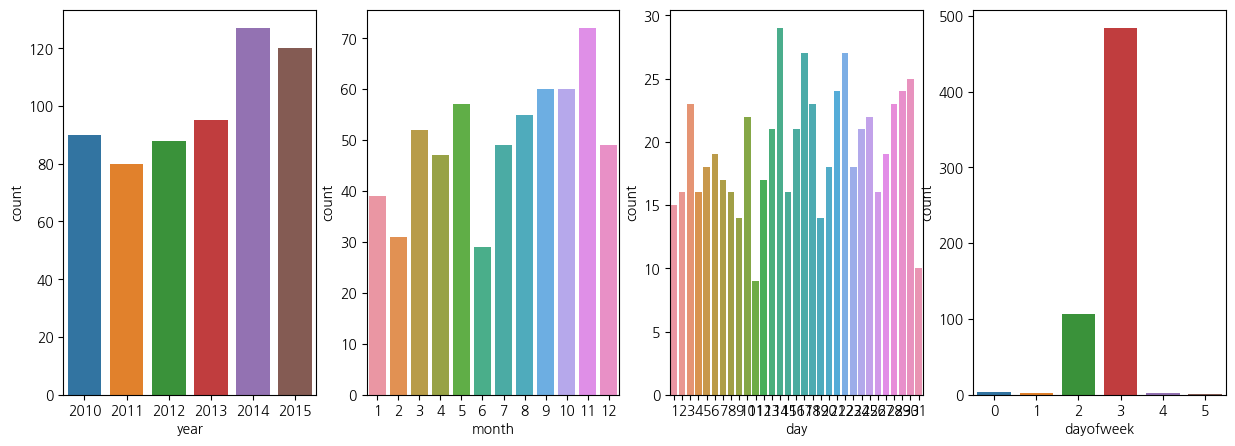

In [40]:
# 요일별로 시각화 해봅니다
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5))

sns.countplot(train["year"], ax=axes[0])
sns.countplot(train["month"], ax=axes[1])
sns.countplot(train["day"], ax=axes[2])
sns.countplot(train["dayofweek"], ax=axes[3])

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [42]:
# 제목과 감독 데이터는 버려줍니다
train = train.drop(["title", "director"], axis=1)
train.columns

Index(['distributor', 'time', 'screening_rat', 'dir_prev_bfnum',
       'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num', 'rank_genre',
       'year', 'month', 'day', 'dayofweek'],
      dtype='object')

In [43]:
test = test.drop(["title", "director"], axis=1)
test.columns

Index(['distributor', 'time', 'screening_rat', 'dir_prev_bfnum',
       'dir_prev_num', 'num_staff', 'num_actor', 'rank_genre', 'year', 'month',
       'day', 'dayofweek'],
      dtype='object')

In [44]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [45]:
# 범주형 데이터들을 인코딩해줍니다
train = pd.get_dummies(data=train)
test = pd.get_dummies(data=test)

In [47]:
display(train.head(2))
display(test.head(2))

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,rank_genre,year,month,day,dayofweek,distributor_소형,distributor_중대형,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,96,0.0,0,91,2,23398,11,2012,11,22,3,0,1,0,0,0,1
1,130,1161602.5,2,387,3,7072501,12,2015,11,19,3,0,1,0,0,0,1


,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,rank_genre,year,month,day,dayofweek,distributor_소형,distributor_중대형,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,125,300529.00,2,304,3,12,2010,1,7,3,1,0,0,0,0,1
1,113,342700.25,4,275,3,5,2010,1,14,3,1,0,1,0,0,0


In [48]:
# 피처와 라벨을 구합니다
label_name = 'box_off_num'
label_name

'box_off_num'

In [50]:
feature_names = ['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'rank_genre', 'year', 'month', 'day', 'dayofweek',
       'distributor_소형', 'distributor_중대형', 'screening_rat_12세 관람가',
       'screening_rat_15세 관람가', 'screening_rat_전체 관람가',
       'screening_rat_청소년 관람불가']
feature_names

['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_소형',
 'distributor_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

### Log Scale

In [57]:
# 등장 배우의 수에 로그 스케일을 적용합니다
train["actor_log1p"] = np.log(train["num_actor"] + 1)

<AxesSubplot:xlabel='actor_log1p', ylabel='Density'>

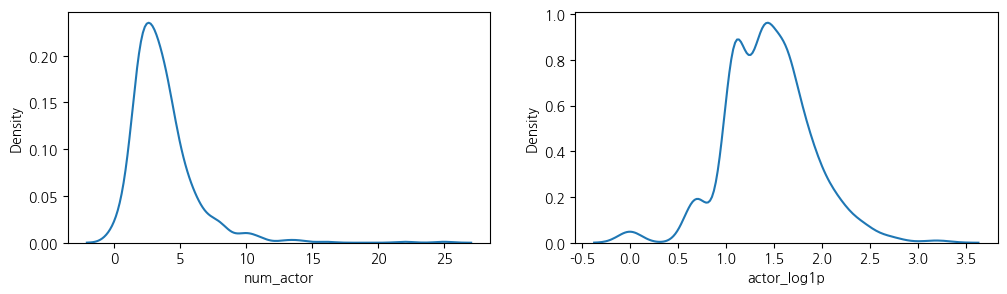

In [58]:
# 정규분포식으로 바뀌는줄 알았는데, 그래프 모양도 같이 바뀌네
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
sns.kdeplot(train["num_actor"], ax=axes[0])
sns.kdeplot(train["actor_log1p"], ax=axes[1])

In [62]:
train = train.drop(["actor_log1p"], axis=1)

In [63]:
train["num_actor"] = np.log(train["num_actor"] + 1)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(train[feature_names], train[label_name], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [65]:
test.shape

(243, 16)

### Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 42, n_jobs=-1)
model

RandomForestRegressor(n_jobs=-1, random_state=42)

In [68]:
y_predict = model.fit(X_train, y_train).predict(X_val)
y_predict[:10]

array([  49430.92,    2153.25,   17669.6 ,  232800.99, 1096314.81,
          8285.09,   56800.13, 1021667.42,    4688.22,   34270.25])

In [69]:
rmse = mean_squared_error(y_val, y_predict)**0.5
rmse

2076932.5384414673

In [71]:
rmse = (((y_val - y_predict) **2).mean()**0.5)
rmse

2076932.5384414678

<AxesSubplot:>

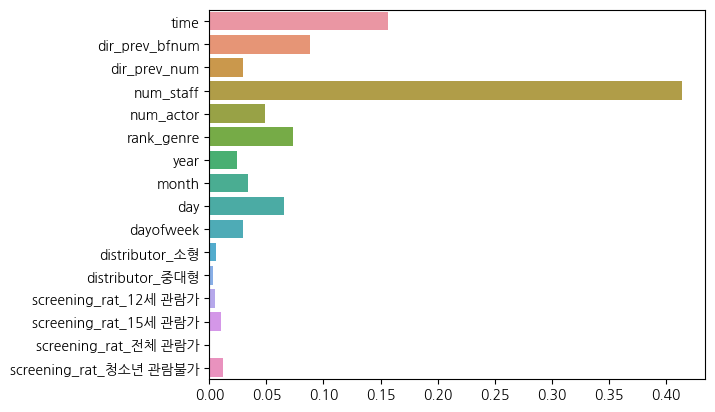

In [72]:
sns.barplot(x=model.feature_importances_, y=model.feature_names_in_)

### XGBoost

In [103]:
xgb_model = XGBRegressor(random_state = 42, n_jobs=-1)
xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [104]:
xgb_predict = xgb_model.fit(X_train, y_train).predict(X_val)

In [105]:
xgb_rmse = mean_squared_error(y_val, xgb_predict) ** 0.5
xgb_rmse
# 랜덤포레스트 : 2076932.5384414678 / XGBoost : 2076932.5384414673

2215286.832010408

In [106]:
from xgboost.plotting import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

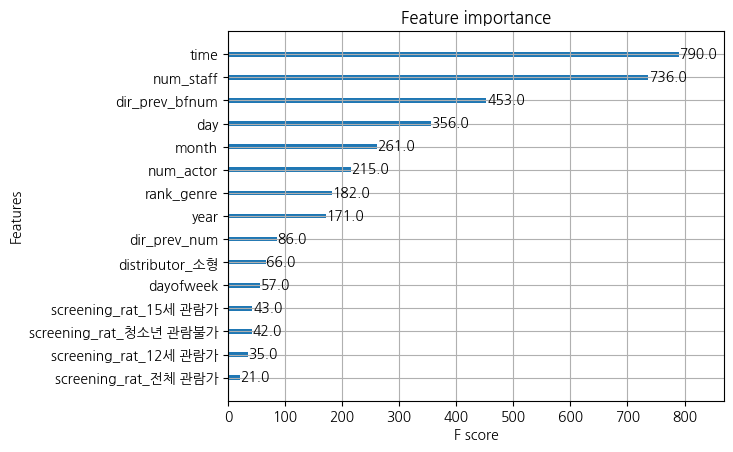

In [107]:
xgb.plot_importance(xgb_model)

### LightGBM

In [108]:
lgbm_model = LGBMRegressor(random_state = 42, n_jobs=-1)
lgbm_model

LGBMRegressor(random_state=42)

In [109]:
lgbm_predict = lgbm_model.fit(X_train, y_train).predict(X_val)

In [110]:
lgbm_rmse = mean_squared_error(y_val, lgbm_predict) **0.5
lgbm_rmse

1933950.072599195

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

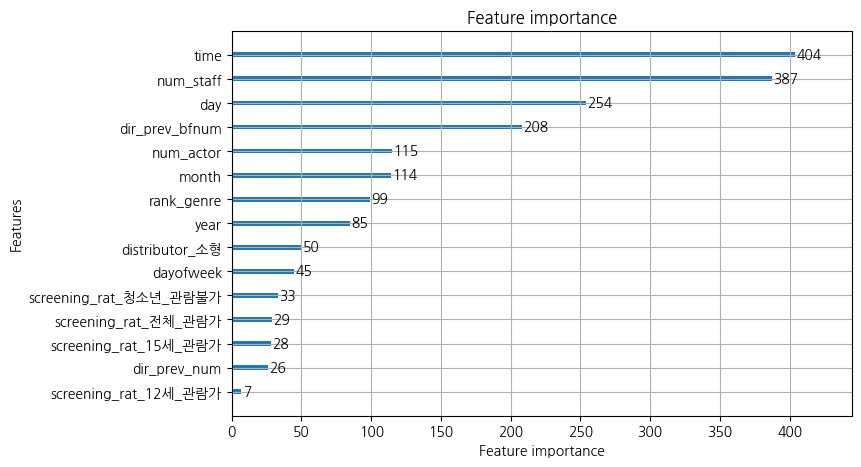

In [114]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (8,5))
plot_importance(lgbm_model, ax=ax)

In [ ]:
# 랜덤포레스트 : 2076932.5384414678
# XGBoost : 2215286.832010408
# LightGBM : 1933950.072599195